In [1]:
import numpy as np

import albumentations as A
import cv2
import torch
import torchvision.transforms as T
import sys

from albumentations.pytorch.transforms import ToTensorV2
from effdet import default_detection_model_configs, load_checkpoint, load_pretrained, EfficientDet, \
                   DetBenchTrain
from effdet.config.model_config import efficientdet_model_param_dict
from omegaconf import OmegaConf
from pathlib import Path
from PIL import Image
from torch import Tensor

import matplotlib.pyplot as plt

In [2]:
sys.path.append('../src')

In [3]:
from data.dataset import WheatDataset
from data.loader import fast_collate
from data.utils import basic_collate

In [4]:
IMAGENET_DEFAULT_MEAN = (0.485, 0.456, 0.406)
IMAGENET_DEFAULT_STD = (0.229, 0.224, 0.225)

DATA_DIR = Path('/media/dmitry/data/global-wheat-detection')

In [5]:
def get_efficientdet_config(model_name='tf_efficientdet_d1'):
    """Get the default config for EfficientDet based on model name."""
    config = default_detection_model_configs()
    config.num_classes = 1
    model_config = efficientdet_model_param_dict[model_name]
    return OmegaConf.merge(config, OmegaConf.create(model_config))

In [6]:
from effdet import create_model_from_config

In [7]:
def create_model(model_name, bench_task='', pretrained=False, checkpoint_path='', 
                 checkpoint_ema=False, **kwargs):    
    config = get_efficientdet_config(model_name)

    pretrained_backbone = kwargs.pop('pretrained_backbone', True)
    if pretrained or checkpoint_path:
        pretrained_backbone = False  # no point in loading backbone weights

    redundant_bias = kwargs.pop('redundant_bias', None)
    if redundant_bias is not None:
        # override config if set to something
        config.redundant_bias = redundant_bias

    model = EfficientDet(config, pretrained_backbone=pretrained_backbone, **kwargs)

    # FIXME handle different head classes / anchors and re-init of necessary layers w/ pretrained load

    if checkpoint_path:
        load_checkpoint(model, checkpoint_path, use_ema=checkpoint_ema)
    elif pretrained:
        load_pretrained(model, config.url)

    # wrap model in task specific bench if set
    if bench_task == 'train':
        model = DetBenchTrain(model, config)
    elif bench_task == 'predict':
        model = DetBenchPredict(model, config)
    return model

In [8]:
get_efficientdet_config('tf_efficientdet_d1')

{'name': 'tf_efficientdet_d1', 'backbone_name': 'tf_efficientnet_b1', 'backbone_args': {'drop_path_rate': 0.2}, 'image_size': 640, 'num_classes': 1, 'min_level': 3, 'max_level': 7, 'num_levels': 5, 'num_scales': 3, 'aspect_ratios': [[1.0, 1.0], [1.4, 0.7], [0.7, 1.4]], 'anchor_scale': 4.0, 'pad_type': 'same', 'act_type': 'swish', 'box_class_repeats': 3, 'fpn_cell_repeats': 4, 'fpn_channels': 88, 'separable_conv': True, 'apply_bn_for_resampling': True, 'conv_after_downsample': False, 'conv_bn_relu_pattern': False, 'use_native_resize_op': False, 'pooling_type': None, 'redundant_bias': True, 'fpn_name': None, 'fpn_config': None, 'fpn_drop_path_rate': 0.0, 'alpha': 0.25, 'gamma': 1.5, 'delta': 0.1, 'box_loss_weight': 50.0, 'url': 'https://github.com/rwightman/efficientdet-pytorch/releases/download/v0.1/tf_efficientdet_d1-4c7ebaf2.pth'}

In [9]:
device = torch.device('cuda:1')

model = create_model(
    'tf_efficientdet_d1', 
    bench_task='train',
    pretrained=False,
    pretrained_backbone=True,
    redundant_bias=None,
    checkpoint_path=''
).to(device)

In [10]:
image_dir = DATA_DIR/'train'
csv_path = DATA_DIR/'train.csv'

tfms = [
    A.Flip(),
    A.RandomRotate90(),
    A.Resize(640, 640, interpolation=cv2.INTER_AREA),
]
tfms = A.Compose(tfms, bbox_params=A.BboxParams('pascal_voc'))

ds = WheatDataset(image_dir, csv_path, transforms=tfms, source=['usask_1'])

Parsing bboxes...: 100%|██████████| 200/200 [00:00<00:00, 1808.21it/s]


In [11]:
dl = torch.utils.data.DataLoader(ds, batch_size=4, shuffle=False, collate_fn=fast_collate)

In [12]:
mean = torch.tensor(IMAGENET_DEFAULT_MEAN).to(device).view(1, 3, 1, 1).mul_(255)
std = torch.tensor(IMAGENET_DEFAULT_STD).to(device).view(1, 3, 1, 1).mul_(255)

In [13]:
batch, out = None, None
model.zero_grad()
model.eval()

for batch in dl:
    x, y = batch
    x = x.permute(0, 3, 1, 2).to(device).float().sub_(mean).div_(std)
    y = {k: v.to(device) for k, v in y.items()}
    out = model(x, y)
    break
    
out.keys()

dict_keys(['loss', 'class_loss', 'box_loss', 'detections'])

In [14]:
from torchvision.utils import save_image

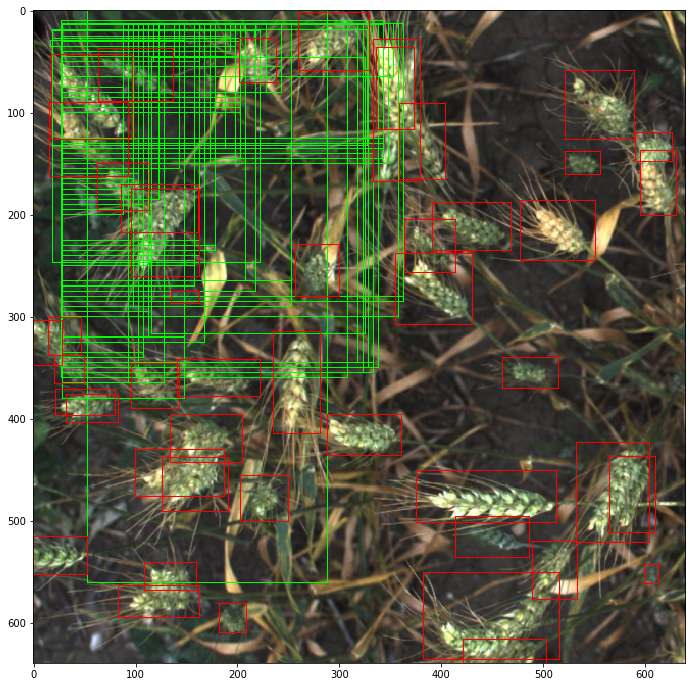

In [15]:
images, targets = batch
i = 0

image = images[i].cpu().numpy()
true_boxes = targets['bbox'][i].cpu().numpy()
pred_boxes = out['detections'][i][:, :4].detach().cpu().numpy()

for box in pred_boxes:
    cv2.rectangle(image, tuple(box[:2]), tuple(box[2:]), (0, 255, 0), 1)

for box in true_boxes:
    cv2.rectangle(image, tuple(box[:2]), tuple(box[2:]), (255, 0, 0), 1)

plt.figure(figsize=(12, 12))
plt.imshow(image)